In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=1

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"Tomato_Disease",
seed=123,
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)

Found 4000 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato Bacterial Spot',
 'Tomato Healthy',
 'Tomato Late Blight',
 'Tomato Yellow Leaf Curl Virus']

In [6]:
for image_batch, labels_batch in dataset.take(1):
   print(image_batch.shape)
   print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 3 2 0 0 1 1 0 3 0 1 2 3 3 1 1 3 0 0 3 1 0 1 3 1 2 3 0 3 2 3]


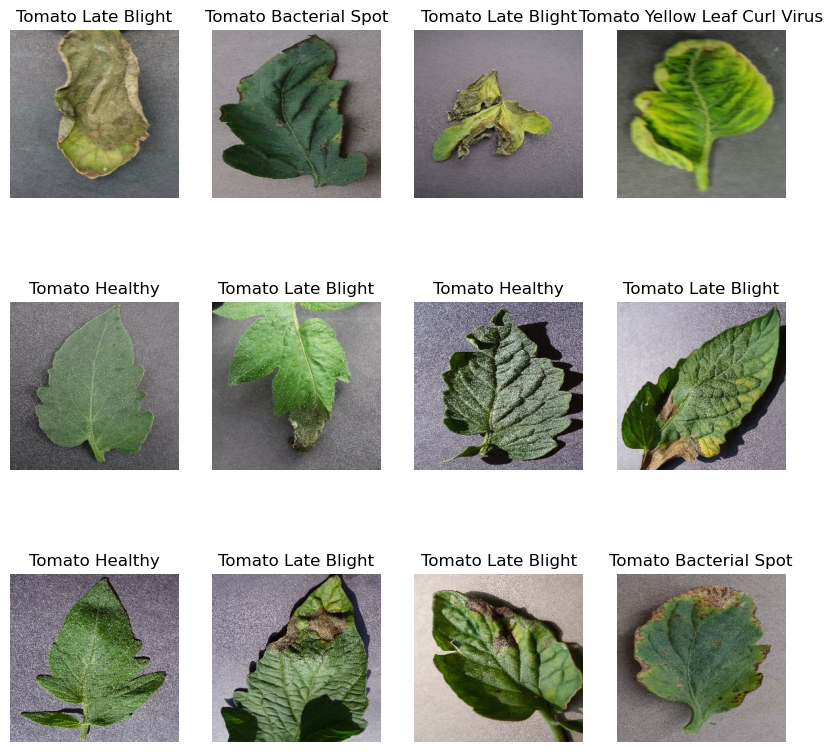

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")



In [8]:
len(dataset)

125

In [9]:
train_size = 0.8
len(dataset) * train_size
train_ds = dataset.take(156)
len(train_ds)
test_ds = dataset.skip(156)
len(test_ds)
val_size = 0.1
len(dataset) * val_size
val_ds = test_ds.take(19)
len(val_ds)
test_ds = test_ds.skip(19)
len(test_ds)


0

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds)
len(val_ds)
len(test_ds)


13

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 14
model = models.Sequential([
resize_and_rescale,
layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, (3, 3), activation='relu'),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, (3, 3), activation='relu'),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, (3, 3), activation='relu'),
layers.MaxPooling2D((2, 2)),
layers.Flatten(),
layers.Dense(64, activation='relu'),
layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [13]:
model.compile(
    optimizer='SGD',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [14]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=1,
)


 24/100 [======>.......................] - ETA: 3:06 - loss: 2.5921 - accuracy: 0.2240

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(test_ds)
scores


In [ ]:
history
history.params
history.history.keys()
type(history.history['loss'])
len(history.history['loss'])
history.history['loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")




In [ ]:
import os
model.save("../faiyaz/models/Tomato_Disease40")